In [1]:
# Run these two blocks to load important libraries and set things up
import torch
from torch import nn
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

## Load Dataset

In [2]:
from torchvision import datasets, transforms

save_dir = 'letterEMNIST'

transform = transforms.ToTensor() # Convert the image into a torch tensor.

train_set = datasets.EMNIST(save_dir, split="letters", download=True, train=True, transform=transform)
test_set = datasets.EMNIST(save_dir, split="letters", download=True, train=False, transform=transform)

print(train_set)
print(test_set)

Dataset EMNIST
    Number of datapoints: 124800
    Root location: letterEMNIST
    Split: Train
    StandardTransform
Transform: ToTensor()
Dataset EMNIST
    Number of datapoints: 20800
    Root location: letterEMNIST
    Split: Test
    StandardTransform
Transform: ToTensor()


In [3]:
from torch.utils.data.sampler import SubsetRandomSampler
ntotal = 60000
ntrain = int(0.9*ntotal)
nval = ntotal - ntrain

val_ix = np.random.choice(range(ntotal), size=nval, replace=False)
train_ix = list(set(range(ntotal)) - set(val_ix))

train_sampler = SubsetRandomSampler(train_ix)
val_sampler = SubsetRandomSampler(val_ix)

In [4]:
# initialize the data sets
batch_size = 64
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, sampler=val_sampler)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size)

['N/A', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
['N/A', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
Label: c


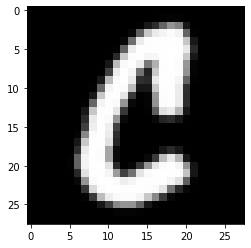

In [5]:
# print classes
print(train_set.classes)
print(test_set.classes)
# print label
index = 50
plt.imshow(train_set.data[index].T, cmap='Greys_r')
print("Label: %s" % train_set.classes[train_set.targets[index]])

## Create the CNN

In [6]:
# inputs are 28x28

class letterMLP(nn.Module):
    def __init__(self, num_letters):
        super().__init__()
        self.classes = num_letters
        self.layers = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(5,5), stride=1),
            nn.MaxPool2d(kernel_size=(2,2), stride=2),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(1152, self.classes)
        )
            

    def forward(self, x):
        return self.layers(x)

In [7]:
model = letterMLP(len(train_set.classes))
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=.0001)

In [8]:
from tqdm.notebook import tqdm
import torch.nn.functional as F

def train_network(model, train_loader, val_loader, criterion, optimizer, nepoch=100):
    try:
        for epoch in tqdm(range(nepoch)):
            print('EPOCH %d'%epoch)
            total_loss = 0
            count = 0
            for inputs, labels in train_loader:
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                total_loss += loss.item()
                count += 1
            print('{:>12s} {:>7.5f}'.format('Train loss:', total_loss/count))
            with torch.no_grad():
                total_loss = 0
                count = 0
                for inputs, labels in val_loader:
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    total_loss += loss.item()
                    count += 1
                print('{:>12s} {:>7.5f}'.format('Val loss:', total_loss/count))
            print()
    except KeyboardInterrupt:
        print('Exiting from training early')
    return

def test_network(model, test_loader):
    correct = 0
    total = 0
    true, pred = [], []
    with torch.no_grad():
        for inputs, labels  in test_loader:
            outputs = model(inputs)
            predicted = torch.argmax(outputs, dim=1) # get predicted class label for each test example.
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            true.append(labels)
            pred.append(predicted)
    acc = (100 * correct / total)

    true = np.concatenate(true)
    pred = np.concatenate(pred)
    return acc, true, pred

In [9]:
train_network(model, train_loader, val_loader, criterion, optimizer, nepoch=10)

  0%|          | 0/10 [00:00<?, ?it/s]

EPOCH 0
 Train loss: 1.95049
   Val loss: 1.25208

EPOCH 1
 Train loss: 1.11897
   Val loss: 1.04646

EPOCH 2
 Train loss: 0.98263
   Val loss: 0.94836

EPOCH 3
 Train loss: 0.89565
   Val loss: 0.87487

EPOCH 4
 Train loss: 0.82348
   Val loss: 0.81060

EPOCH 5
 Train loss: 0.76208
   Val loss: 0.75350

EPOCH 6
 Train loss: 0.70946
   Val loss: 0.70754

EPOCH 7
 Train loss: 0.66473
   Val loss: 0.67009

EPOCH 8
 Train loss: 0.62603
   Val loss: 0.63878

EPOCH 9
 Train loss: 0.59349
   Val loss: 0.60949



Test accuracy: 82.495


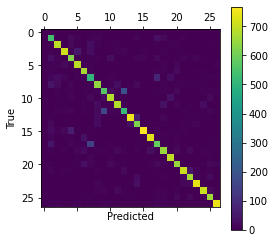

In [12]:
acc, true, pred = test_network(model, test_loader)
print('Test accuracy: %0.3f' % acc)

contingency = np.zeros((model.classes, model.classes))
for i in range(len(pred)):
    contingency[int(pred[i])][int(true[i])] += 1

plt.matshow(contingency)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.colorbar()

## Letter Visualizations